# Runs the file containing general functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [1]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [16]:
# Package names
packages<-c("dplyr", "lubridate", "ggplot2", "ggpubr")
packageHandler(packages)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# 1. Script specific functions

## Function that takes a dataframe and pulls the last complete {sampleCount} readings from the first hour and last hour and returns them as a dataframe

In [22]:
calibration_samples<-function(df, timeCol="time.h", uuidCol="uuid", sampleCount=5){
    # get time range of dataframe
    df_range<-range(df[[timeCol]])
    
    # set first hour time frame
    first_start<-round(df_range[1], units="hours")
    first_end<-first_start+(1*60*60)
    
    # set last hour time frame
    last_end<-round(df_range[2], units="hours")
    last_start<-last_end-(1*60*60)
    
    # count number of unique devices in data frame
    uuid_count<-length( unique(df[[uuidCol]]) )
    
    # calculate total sample size to be returned per hour
    total_sample_size<-uuid_count*sampleCount 
    
    # create first hour subset
    first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    
    # ensure first hour has data from each device
    while( length(unique(first_hour[[uuidCol]])) != uuid_count ){
        first_start<-first_start+(1*60*60)
        first_end<-first_end+(1*60*60)
        first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    }
    # move to subset of last values in the hour
    first_start<-first_end-(sampleCount*60)
    
    # remake the subset and check it has sampleCount values per device
    first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    while ( length(first_hour[[1]]) != total_sample_size ){
        first_start <- first_start - (1*60)
        first_end <- first_end - (1*60)
        first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    }
    first_hour$relative_hour<-"first hour"
    
    #repeat for last_hour, TODO: combine into a loop, but switch +/- for first/last?
    last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    while( length(unique(last_hour[[uuidCol]])) != uuid_count ){
        last_start<-last_start-(1*60*60)
        last_end<-last_end-(1*60*60)
        last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    }
    last_start<-last_end-(sampleCount*60)
    last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    while ( length(last_hour[[1]]) != total_sample_size ){
        last_start <- last_start - (1*60)
        last_end <- last_end - (1*60)
        last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    }
    last_hour$relative_hour<-"last hour"
    
    # debug messages, final timestamps used
    print(first_start)
    print(first_end)
    print(last_start)
    print(last_end)
    
    # return both subsets combined
    return( rbind(first_hour, last_hour) )
}

## Function that takes a single directory and does the processing for it
1. concatenate data
2. process columns
3. subset "summary" lines
4. run those lines through calibration_samples function
5. save output to csv
6. create and save basic plots of variables vs time.h

In [29]:
extractSamples<-function(directory){
    rriv<-paste(sep="",directory,"/RRIV")
    data<-concat_dirs(rriv, read_rriv_CSV, minFileSize=300)
    data<-process_rriv_columns(data)
#     raw_data<-subset(data, type=="raw")
    summary_data<-subset(data, type=="summary")
    outputDir<-paste(rriv,"_output/",sep="")
    newDir(outputDir)

    samples<-calibration_samples(summary_data)
    ppm_tag<-gsub(".*_(.+)ppm_.*", "\\1", rriv)
    ppm_tag<-paste(ppm_tag,"ppm",sep="")
    saveDFcsv(samples,ppm_tag,od=outputDir)
    sample_plots<-plot_Data_v_Time(samples,"site")
    savePlotList(sample_plots, "sample_plots_")
}

In [3]:
exDirectory

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"

In [65]:
gsub(".*a/(.+)./.*", "\\1", exDirectory)

[1] "Methane Calibration/concentration_test"

In [5]:
exDirectory[1]

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"

# RUN

In [11]:
# Location of all concentration test runs
    # these are experiments that had gas samples pulled for them
directory<-"~/Desktop/data/Methane Calibration/concentration_tests"

## Get sample data from each experiment
### Sample data consists of 5 readings from both the ends of the first hour and last hour where all sensors were running

# Process every experiment at once

In [6]:
experiments<-list.dirs(directory, recursive=FALSE)
experiments

[1] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"
[2] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330" 
[3] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130"  
[4] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139" 
[5] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150"   
[6] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115"

In [30]:
# for(i in experiments){
#     rriv<-paste(sep="",i,"/RRIV")
#     if(dir.exists(rriv)){
#         extractSamples(i)
#     } else{
#         print("ERROR: RRIV folder for experiment not found")
#         break
#     }
# }

[1] "Dataframe generated, manually process column types if necessary"
Output directory not found, creating: /home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV_output/
[1] "2023-02-20 23:55:00 UTC"
[1] "2023-02-21 UTC"
[1] "2023-02-21 16:55:00 UTC"
[1] "2023-02-21 17:00:00 UTC"
[1] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV_output/samples_1000ppm.csv"
[1] "Dataframe generated, manually process column types if necessary"
Output directory, /home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330/RRIV_output/, already exists
[1] "2023-02-21 22:55:00 UTC"
[1] "2023-02-21 23:00:00 UTC"
[1] "2023-02-22 17:55:00 UTC"
[1] "2023-02-22 18:00:00 UTC"
[1] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330/RRIV_output/samples_100ppm.csv"
[1] "Dataframe generated, manually process column types if

# Process a single experiment directory

In [2]:
# note: do not include final /
exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115"

In [32]:
extractSamples(exDirectory)

[1] "Dataframe generated, manually process column types if necessary"
Output directory, ~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV_output/, already exists
[1] "2023-02-20 23:55:00 UTC"
[1] "2023-02-21 UTC"
[1] "2023-02-21 16:55:00 UTC"
[1] "2023-02-21 17:00:00 UTC"
[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV_output/samples_1000ppm.csv"


## Concatenate all sampled data

In [12]:
# filePattern<-"samples(.+).csv"
# Files<-list.files(path=directory, recursive=TRUE, pattern=filePattern, full.names=TRUE)
# Files

sample_data<-concat_dirs(directory,read_rriv_CSV,filePattern="samples(.+).csv")
sample_data<-process_rriv_columns(sample_data)

[1] "Dataframe generated, manually process column types if necessary"


'data.frame':	360 obs. of  21 variables:
 $ X               : int  4201 4276 4351 4426 4501 87021 87771 88521 89271 90021 ...
 $ type            : Factor w/ 1 level "summary": 1 1 1 1 1 1 1 1 1 1 ...
 $ site            : Factor w/ 6 levels "C1","C2","C3",..: 1 1 1 1 1 2 2 2 2 2 ...
 $ logger          : Factor w/ 6 levels "21001","21010",..: 2 2 2 2 2 3 3 3 3 3 ...
 $ deployment      : Factor w/ 36 levels "calCH001-57FF70068387575129270167-1676933668",..: 1 1 1 1 1 7 7 7 7 7 ...
 $ deployed_at     : int  1676933668 1676933668 1676933668 1676933668 1676933668 1676928414 1676928414 1676928414 1676928414 1676928414 ...
 $ uuid            : Factor w/ 6 levels "50FF6C068678545210222467",..: 5 5 5 5 5 3 3 3 3 3 ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : POSIXct, format: "2023-02-20 23:55:29" "2023-02-20 23:56:30" ...
 $ battery.V       : num  1453 1429 1445 1441 1433 ...
 $ measurementCycle: num  1 1 1 1 1 2 2 2 2 2 ...
 $ burstCycle   

## save to csv (for visual inspection)

In [13]:
saveDFcsv(sample_data,tag ="allExperiments", paste(directory,"/",sep=""))

[1] "~/Desktop/data/Methane Calibration/concentration_tests/sample_data_allExperiments.csv"


In [48]:
# head(sample_data)

# average data for each 5 readings, which can be achieved by grouping by one of the ID columns, measurement cycle, and deployment or deployed_at column

In [14]:
average_ppm_runs<-function(df){
    grouped <- group_by(df, site, deployed_at, measurementCycle)
    means <- summarise(grouped,
                       type=type,
                       site=site,
                       deployment=deployment,
                       deployed_at=deployed_at,
                       uuid=uuid,
                       time.s=mean(time.s),
                       time.h=mean(time.h),
                       battery.V=mean(battery.V),
                       ch4rf_raw=mean(ch4rf_raw),
                       ch4rf_cal=mean(ch4rf_cal),
                       ch4_raw=mean(ch4_raw),
                       ch4_cal=mean(ch4_cal),
                       dht_C=mean(dht_C),
                       dht_RH=mean(dht_RH),
#                        ch4_ppm=mean(ch4_ppm)
                       relative_hour=relative_hour
                      )
    return(means)
}

In [54]:
# str(sample_data)
class(sample_data$time.h)

[1] "POSIXct" "POSIXt"

In [17]:
sampleMeans<-average_ppm_runs(sample_data)
sampleMeans

`summarise()` has grouped output by 'site', 'deployed_at', 'measurementCycle'. You can override using the `.groups` argument.



site,deployed_at,measurementCycle,type,deployment,uuid,time.s,time.h,battery.V,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,dht_C,dht_RH,relative_hour
<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,0,1597.38,0,25.400,23.100,last hour
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,0,1597.38,0,25.400,23.100,last hour
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,0,1597.38,0,25.400,23.100,last hour
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,0,1597.38,0,25.400,23.100,last hour


## calculate absolute humidity

In [19]:
df<-sampleMeans
df$dht_K<-df$dht_C+273.15

#determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
P<-1013.25 #millibar, standard pressure ~1 atmosphere
df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
df$ews_kPa<-df$ews_mbar/10

#convert relative humidity to molar PPM (https://www.learnthermo.com/examples/ch02/p-2d-9.php)
# note: assuming 1 atmosphere, 101.325 kPa, and volume of 1
df$H2O_mol<-df$dht_RH*df$ews_kPa/101.325
df$BDA_mol<-1-df$H2O_mol #mass of dry air

MW_H2O<-18.01528
MW_BDA<-28.97

df$MW_gas<-df$BDA_mol*MW_BDA+df$H2O_mol*MW_H2O


#vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
C<-2.16679 #gK/J
# df$aH_gm3<-C*df$PH2O_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)

head(df)
sampleMeans<-df

site,deployed_at,measurementCycle,type,deployment,uuid,time.s,time.h,battery.V,ch4rf_raw,⋯,dht_C,dht_RH,relative_hour,dht_K,ews_mbar,ews_kPa,H2O_mol,BDA_mol,MW_gas,aH_gm3
<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,⋯,25.052,23.992,first hour,298.202,19.85961,1.985961,0.4702411,0.5297589,23.81864,3.462131
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,⋯,25.052,23.992,first hour,298.202,19.85961,1.985961,0.4702411,0.5297589,23.81864,3.462131
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,⋯,25.052,23.992,first hour,298.202,19.85961,1.985961,0.4702411,0.5297589,23.81864,3.462131
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,⋯,25.052,23.992,first hour,298.202,19.85961,1.985961,0.4702411,0.5297589,23.81864,3.462131
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,⋯,25.052,23.992,first hour,298.202,19.85961,1.985961,0.4702411,0.5297589,23.81864,3.462131
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,⋯,25.400,23.100,last hour,298.550,20.61856,2.061856,0.4700604,0.5299396,23.82062,3.456767


## Save results to csv

In [20]:
saveDFcsv(sampleMeans,od=paste(directory,"/",sep=""))

[1] "~/Desktop/data/Methane Calibration/concentration_tests/sampleMeans.csv"


# Basic plots

In [23]:
variableDict<-getDict(sampleMeans)

variableDict<-append(variableDict,c("aH_gm3"="Absolute Humidity (g/m^3)"))

variableCount<-length(variableDict)
variableKeys<-names(variableDict)

variableDict

battery.V 
                     "Battery Digital\nReading (12bit)" 
                                                  dht_C 
                                   "\nTemperature (°C)" 
                                                 dht_RH 
                              "\nRelative Humidity (%)" 
                                              ch4rf_raw 
       "Raw Methane Reference\nDigital Reading (12bit)" 
                                              ch4rf_cal 
"Calibrated Methane Reference\nDigital Reading (12bit)" 
                                                ch4_raw 
                 "Raw Methane Digital\nReading (12bit)" 
                                                ch4_cal 
          "Calibrated Methane Digital\nReading (12bit)" 
                                                 aH_gm3 
                            "Absolute Humidity (g/m^3)"

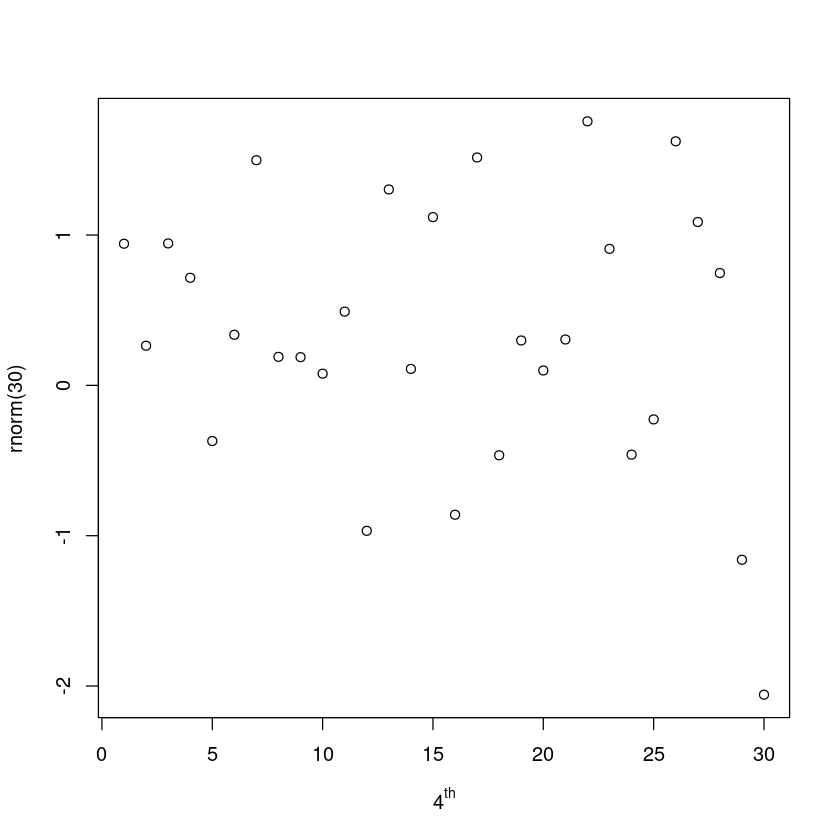

In [7]:
# examples of labels with exponents?
# parse(text='70^o*N')
test<-expression(paste("4"^"th"))
plot(rnorm(30), xlab = test)

In [72]:
plot_Data_v_Time_2 <-function(df, color="logger", timeCol="time.h", vd=variableDict, vk=variableKeys, vc=variableCount){
  # initialize list to hold plots
  DvT = vector('list', vc)
  names(DvT) = names(vd)
  
  # plot each column vs time with all deployments into list
  for ( i in 1:vc ){
    DvT[[i]] = ggplot(data=df,aes_string(x=timeCol,y=vk[i],color=color),size=1)+
      geom_point()+theme_classic(base_size=12)+
      labs(x="Date", y=vd[i], color=NULL)
    # +
    #   scale_color_manual(values=custom_colors2,na.translate=F)+
    #   scale_x_datetime(date_labels="%m/%d %H",breaks=scales::pretty_breaks(n=4),expand=c(0,60*5))
  }
  return(DvT)
}

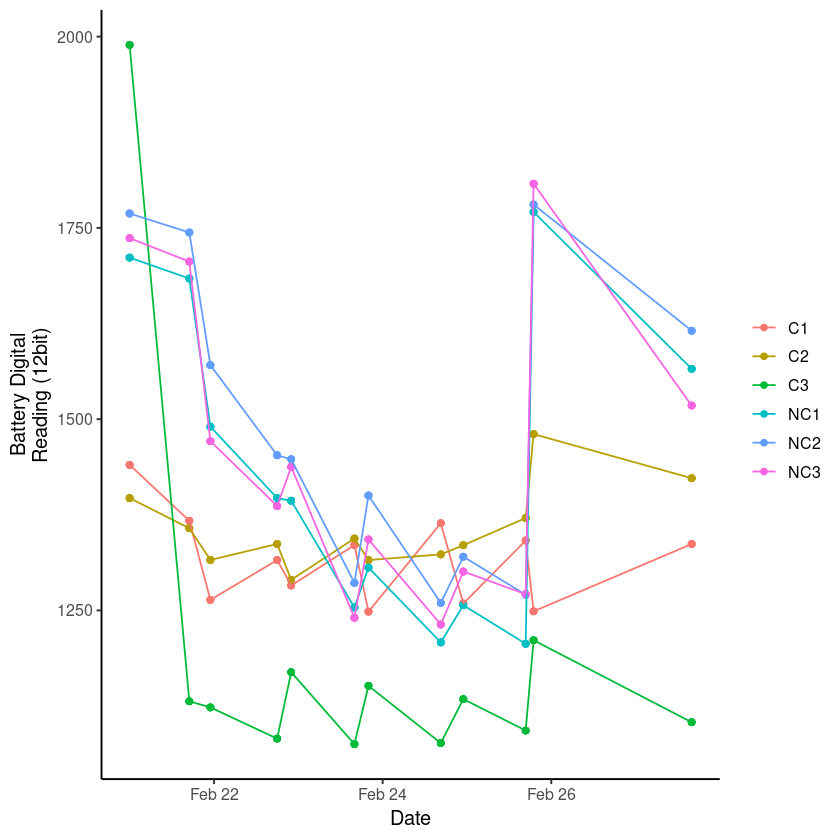

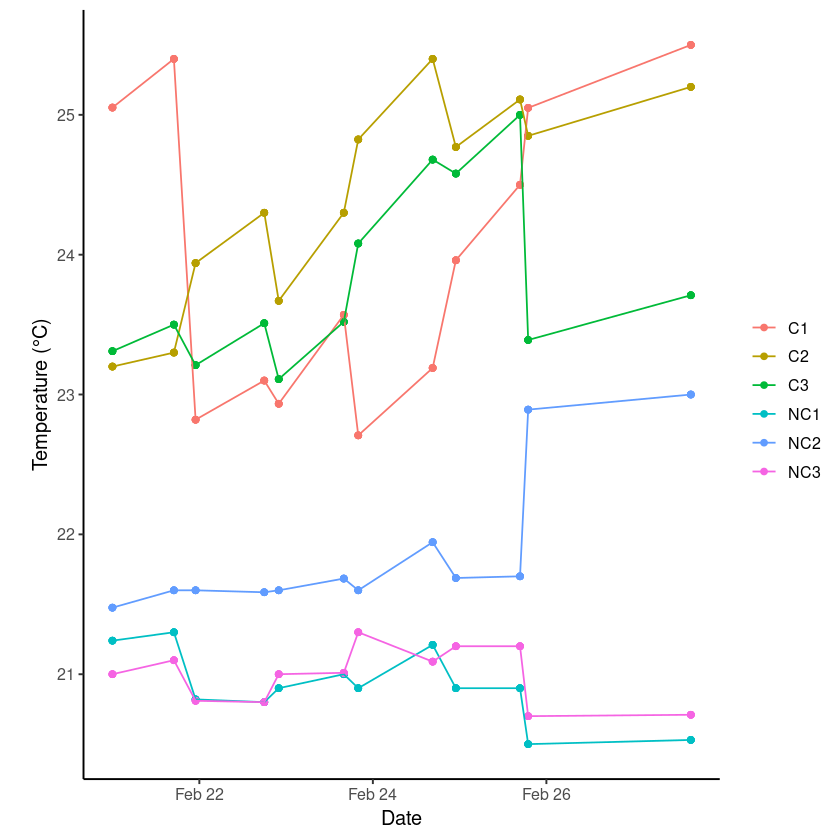

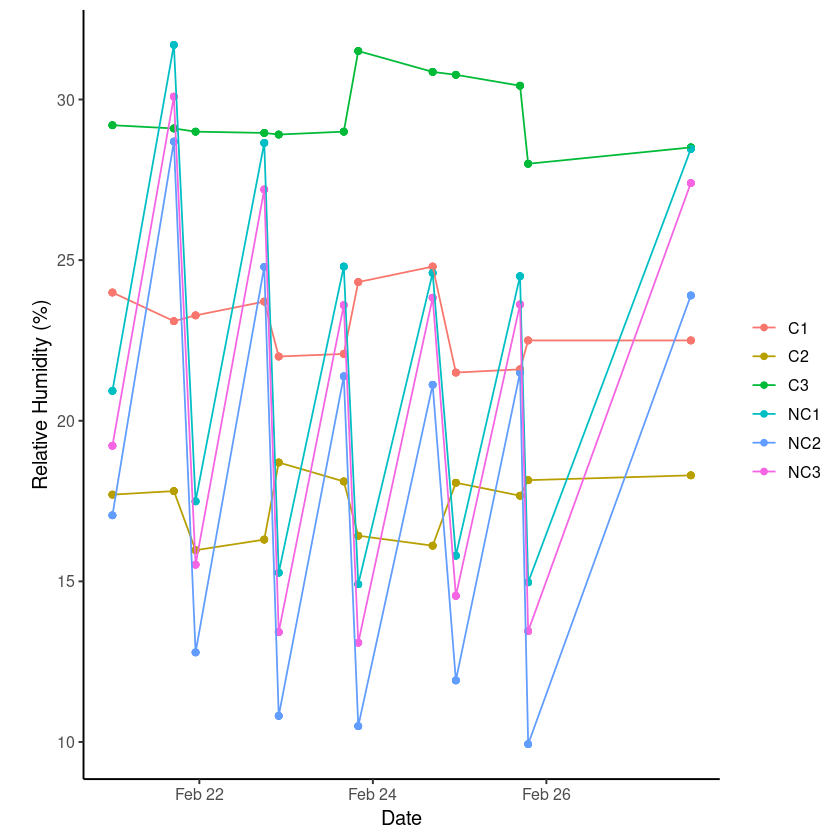

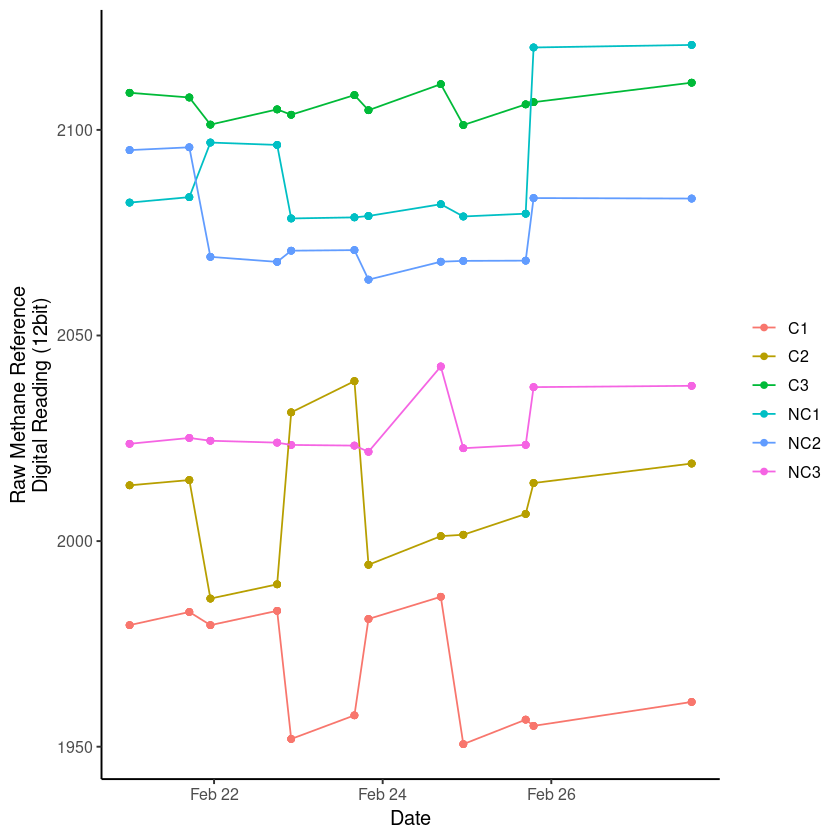

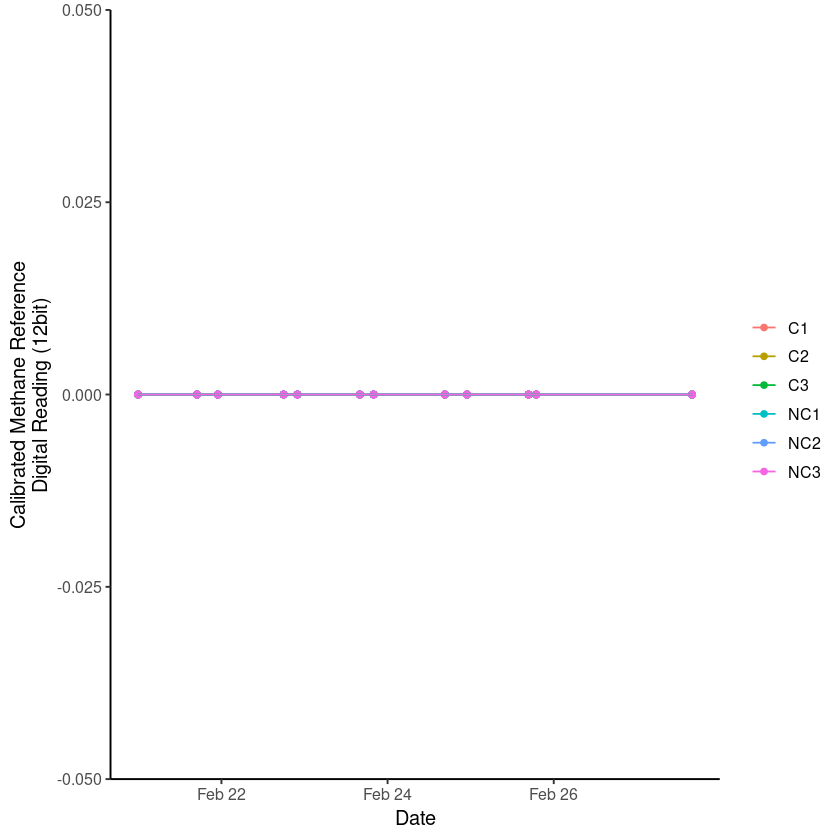

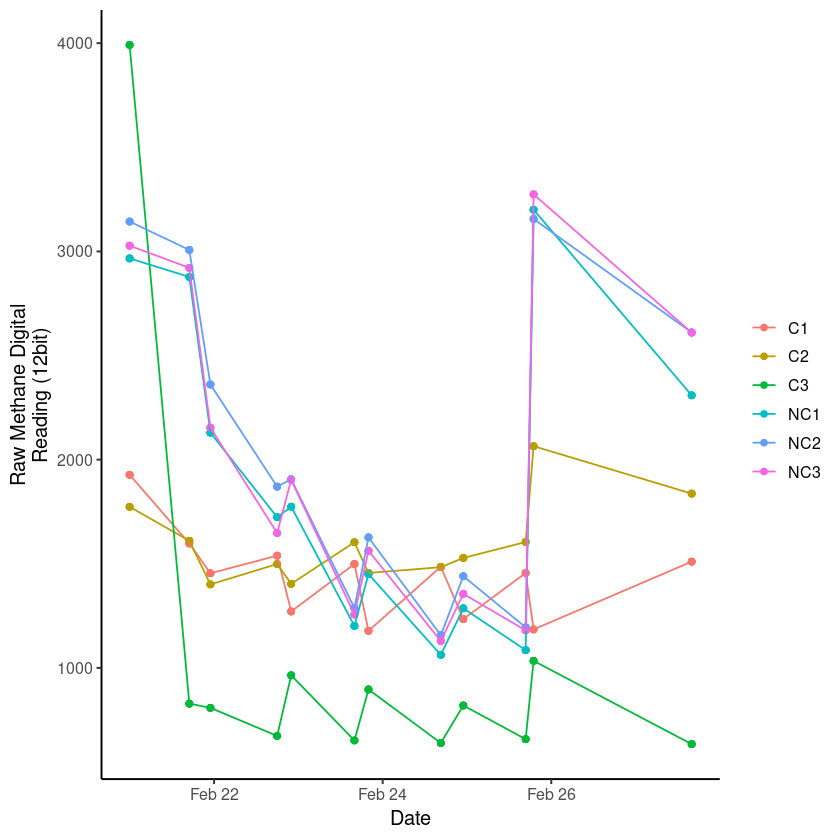

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


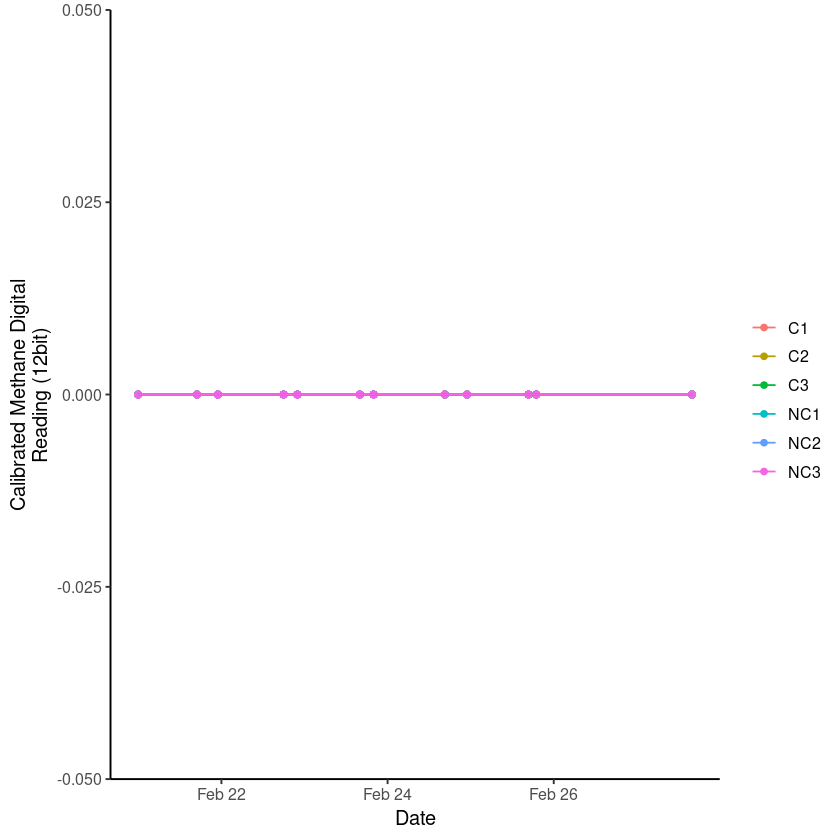

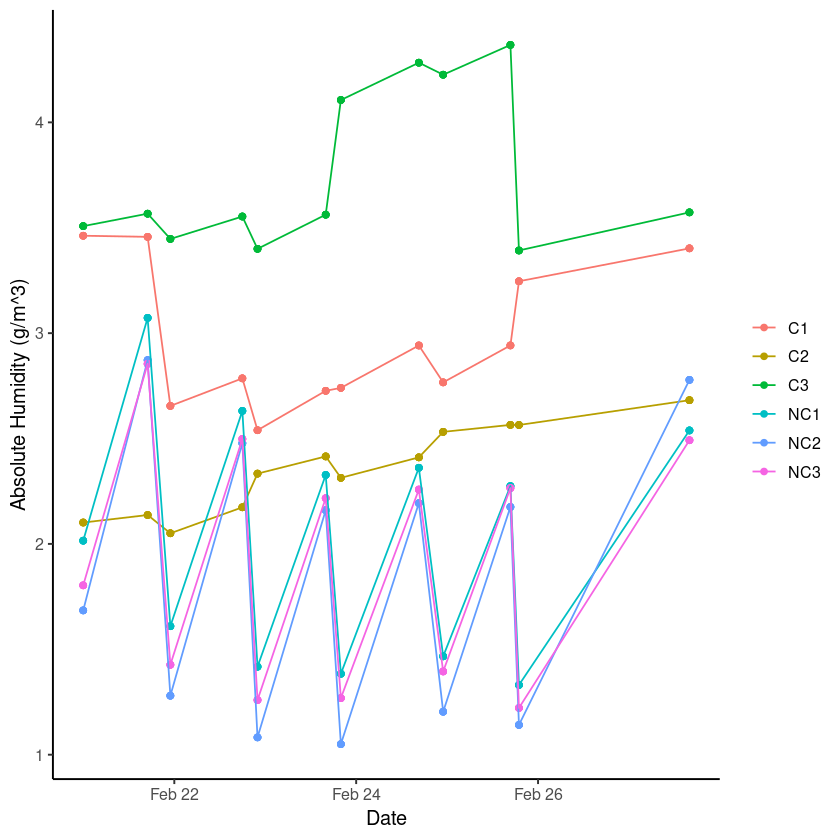

In [26]:
sampleMeans_plots<-plot_Data_v_Time(sampleMeans,color="site")
sampleMeans_plots

savePlotList(sampleMeans_plots, od=paste(directory,"/",sep=""))

In [29]:
# str(sampleMeans)
first_hour_sM<-sampleMeans[sampleMeans$relative_hour == "first hour",]
last_hour_sM<-sampleMeans[sampleMeans$relative_hour == "last hour",]

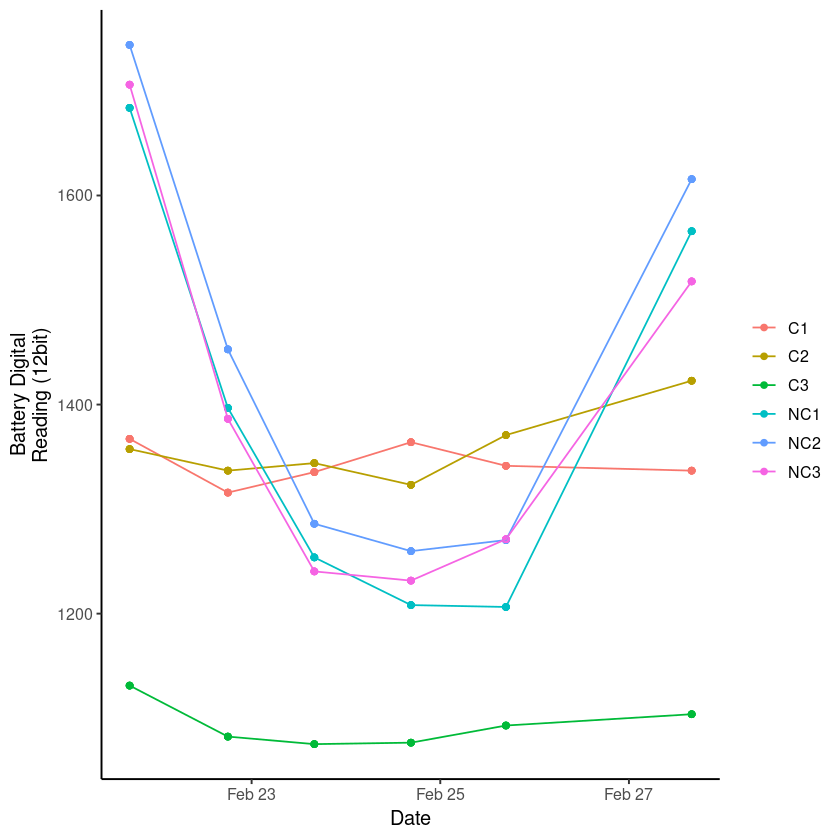

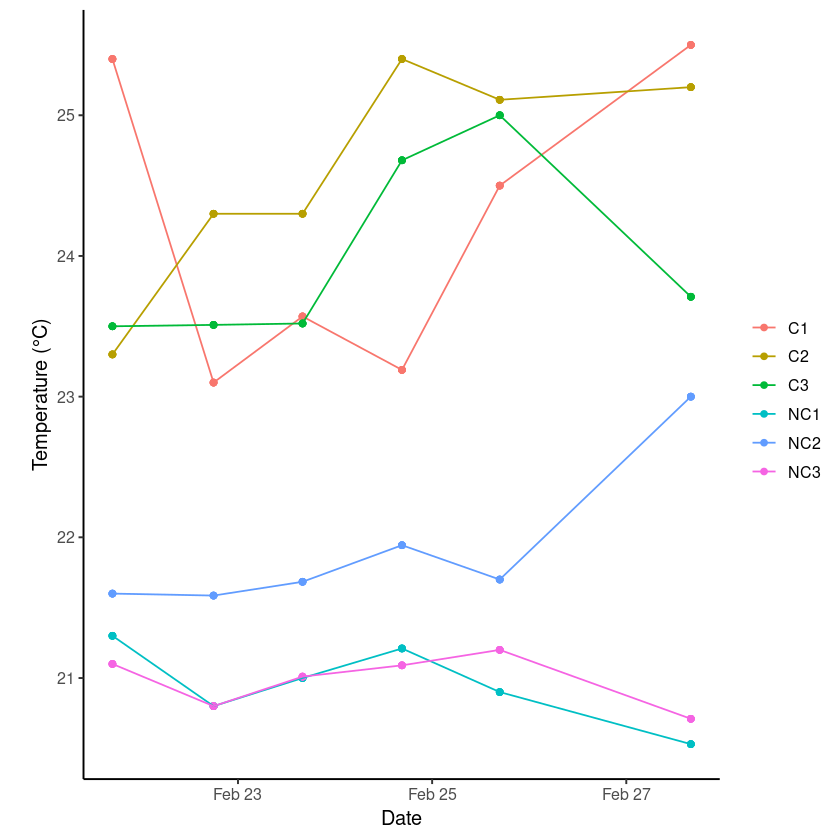

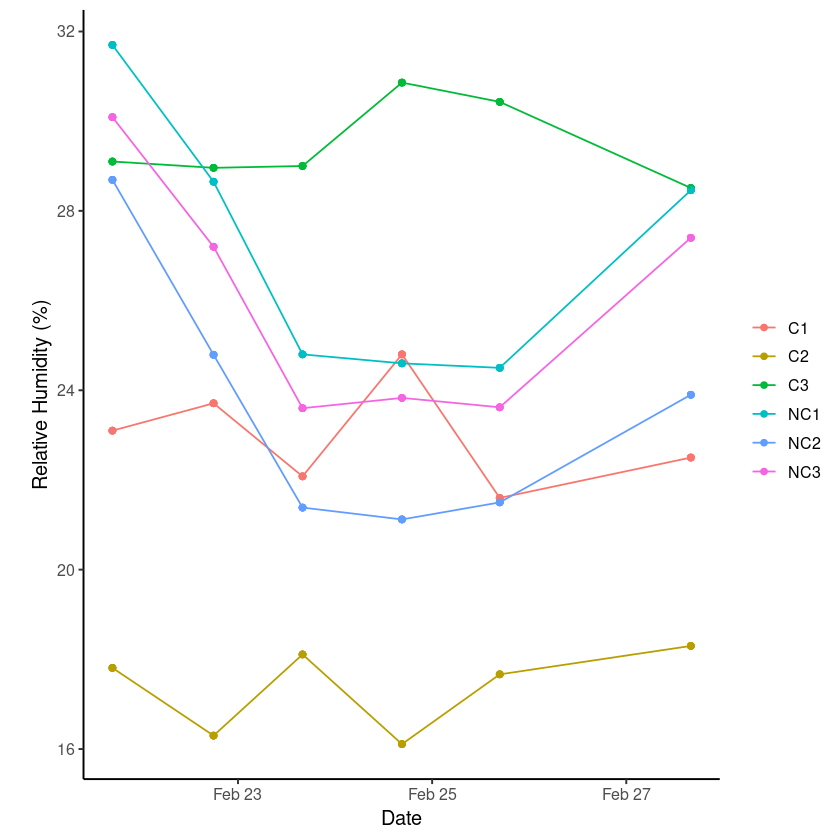

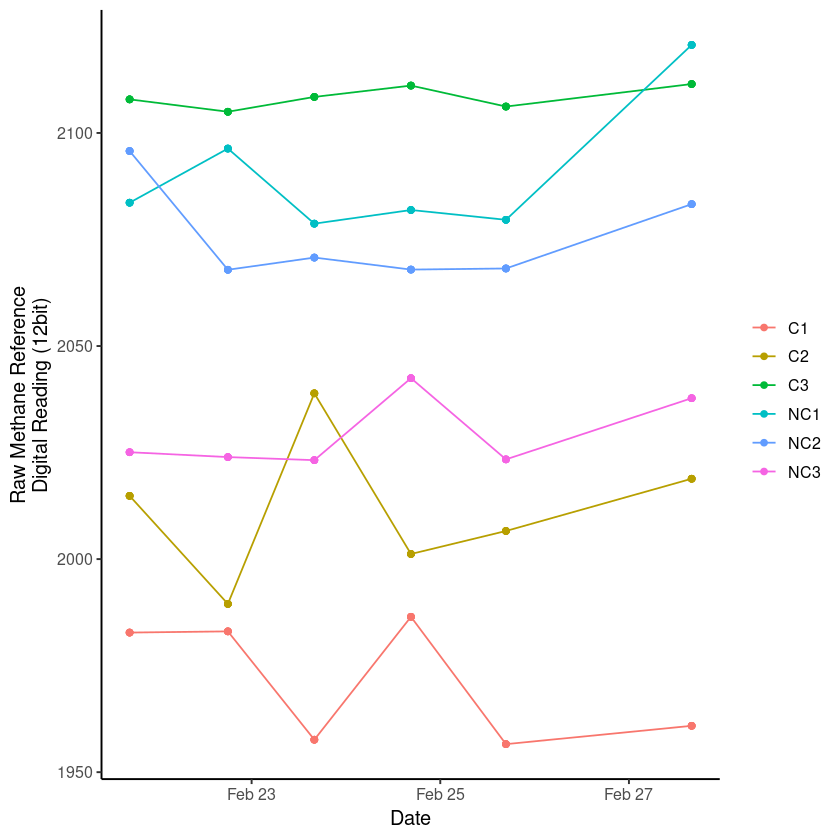

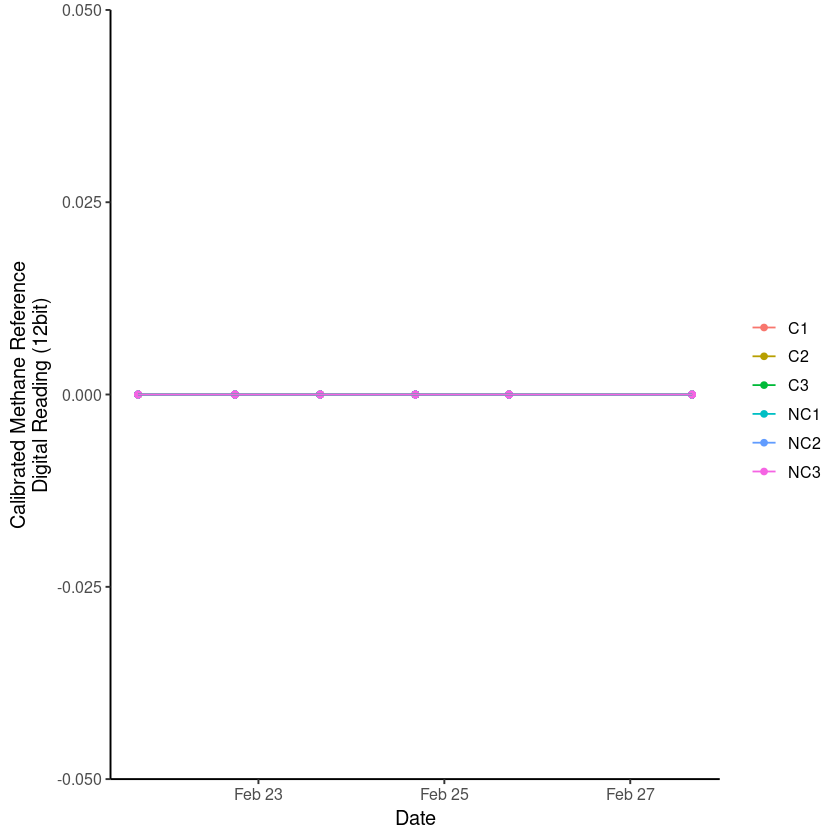

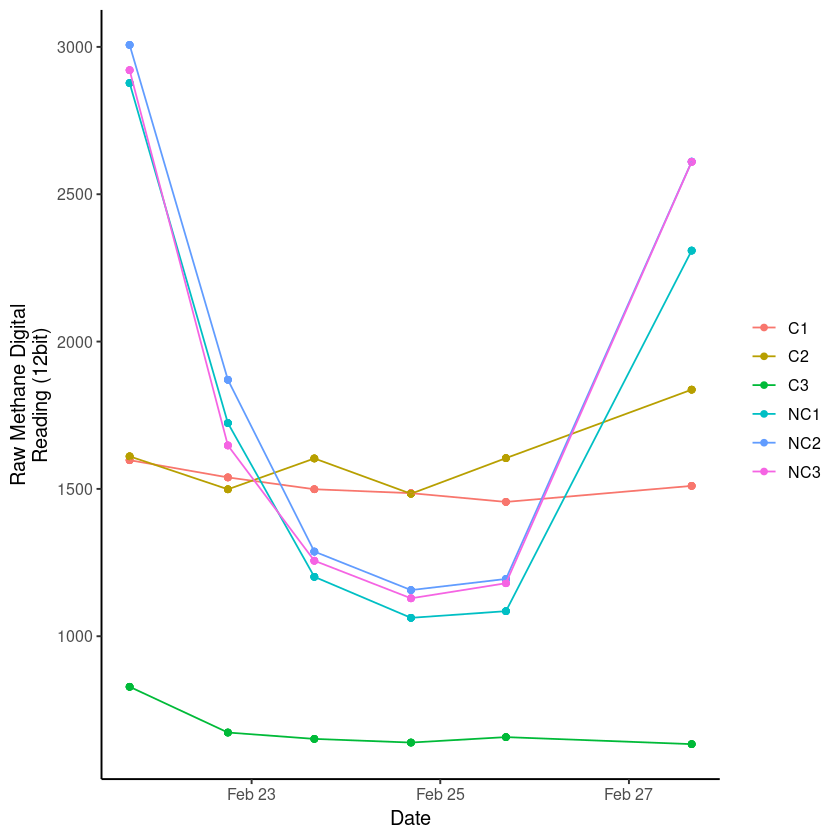

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


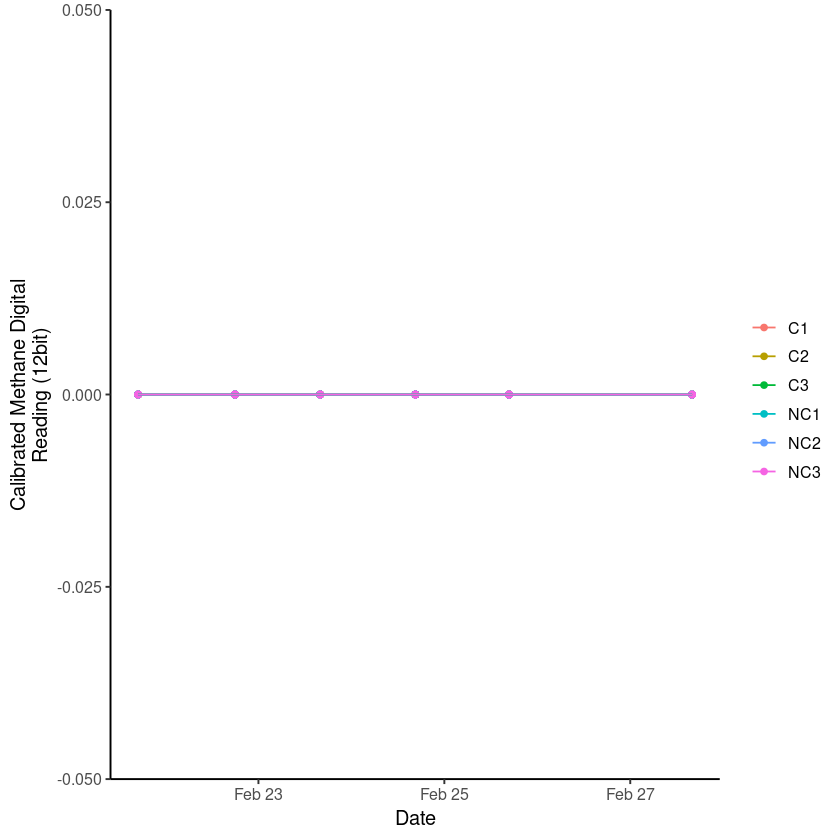

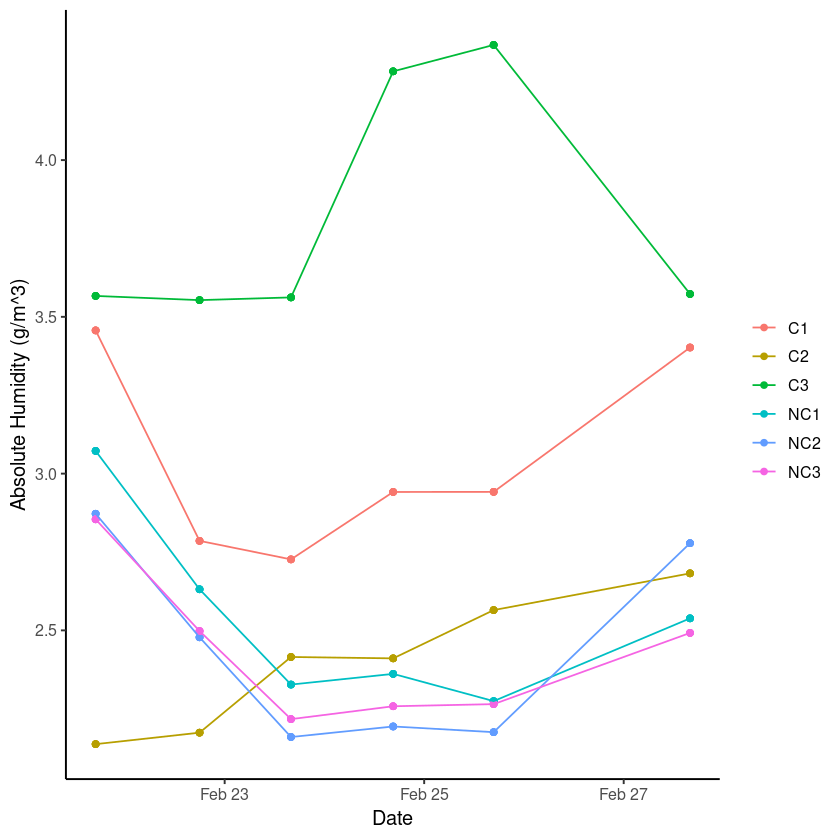

In [30]:
sampleMeans_last_plots<-plot_Data_v_Time(last_hour_sM,color="site")
sampleMeans_last_plots

[1] "site"             "deployed_at"      "measurementCycle" "type"            
 [5] "deployment"       "uuid"             "time.s"           "time.h"          
 [9] "battery.V"        "ch4rf_raw"        "ch4rf_cal"        "ch4_raw"         
[13] "ch4_cal"          "dht_C"            "dht_RH"           "relative_hour"   
[17] "dht_K"            "ews_mbar"         "ews_kPa"          "H2O_mol"         
[21] "BDA_mol"          "MW_gas"           "aH_gm3"

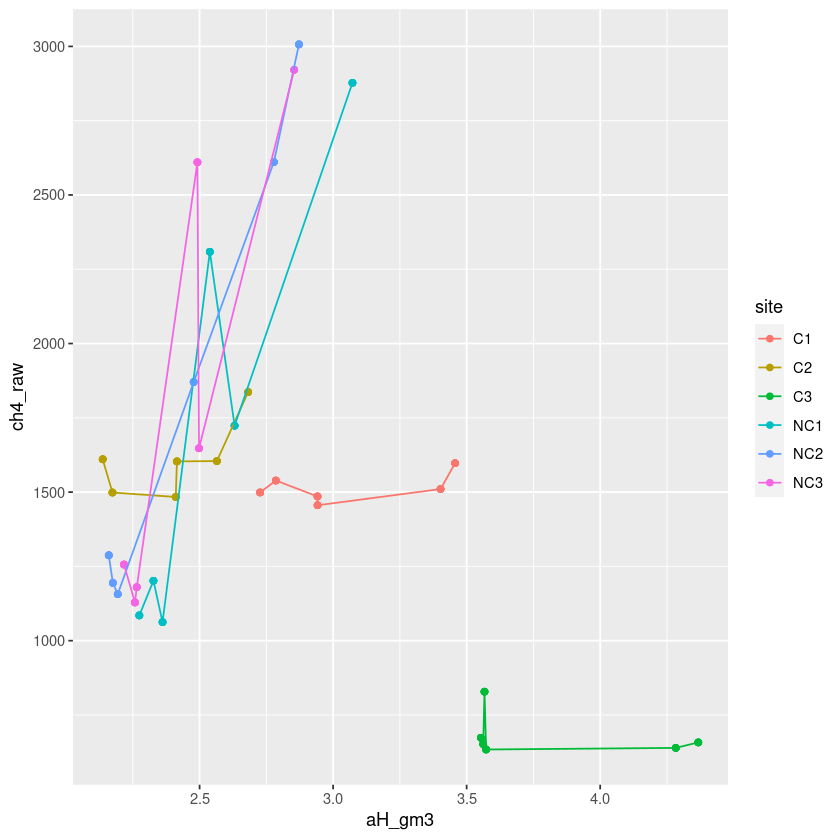

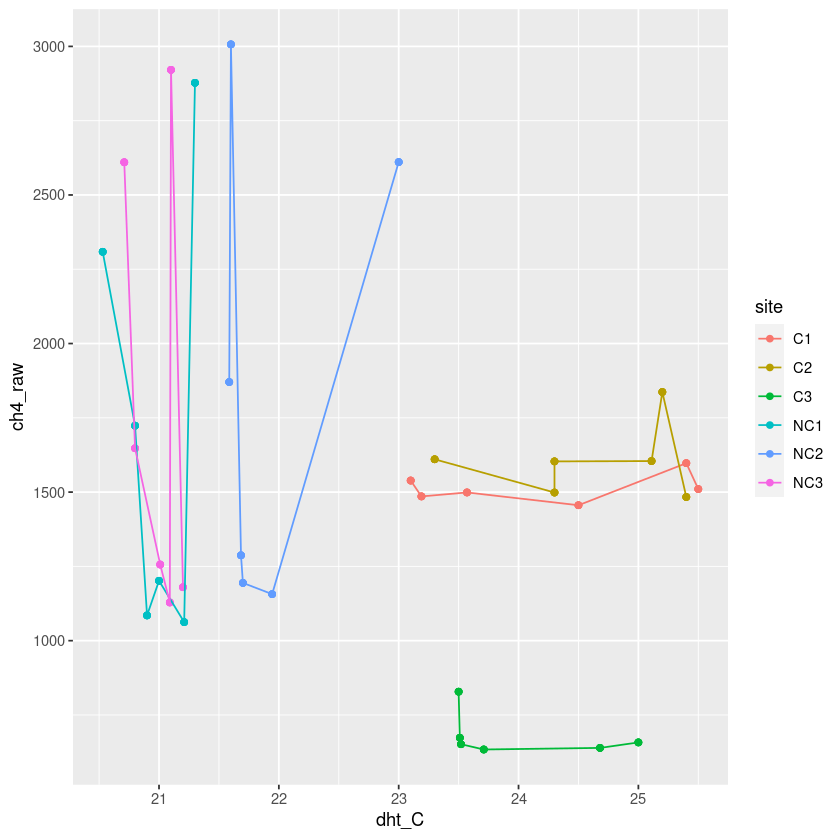

In [37]:
# methane vs humidity
ggplot(last_hour_sM, aes(x=aH_gm3, y=ch4_raw, color=site))+geom_point()+geom_line()

# methane vs temperature
ggplot(last_hour_sM, aes(x=dht_C, y=ch4_raw, color=site))+geom_point()+geom_line()